# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 14: Avoided Crossing part 3  FIRE-dDNP (1H to 13C Polarization Transfer)
FIRE-dDNP: Field Inversion Results in enhancement - dDNP. An adiabatic magnetic field inversion to transfer Zeeman order between hetronuclear spins via J coupling.

In this simulation I consider 3-13C-Pyruvate (Figure S2 in SI). For more details look into the reference.

Reference: Rapid and Simple 13C-Hyperpolarization by 1H Dissolution Dynamic Nuclear Polarization Followed by an Inline Magnetic Field Inversion, Quentin Stern, et.al., https://doi.org/10.1021/jacs.3c09209

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [20]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_v1.0/Source'

In [21]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [22]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2,1/2,1/2] # [1H,1H,1H,13C]

In [23]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [24]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

In [25]:
formating = "list" # Options: "list" or "array"
AM = System.Basis_Ket_AngularMomentum(Sz,formating)
AM

['2',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '-1',
 '1',
 '0',
 '0',
 '-1',
 '0',
 '-1',
 '-1',
 '-2']

In [26]:
ket = System.Basis_Ket()
ket

['|1/2,1/2>|1/2,1/2>|1/2,1/2>|1/2,1/2>',
 '|1/2,1/2>|1/2,1/2>|1/2,1/2>|1/2,-1/2>',
 '|1/2,1/2>|1/2,1/2>|1/2,-1/2>|1/2,1/2>',
 '|1/2,1/2>|1/2,1/2>|1/2,-1/2>|1/2,-1/2>',
 '|1/2,1/2>|1/2,-1/2>|1/2,1/2>|1/2,1/2>',
 '|1/2,1/2>|1/2,-1/2>|1/2,1/2>|1/2,-1/2>',
 '|1/2,1/2>|1/2,-1/2>|1/2,-1/2>|1/2,1/2>',
 '|1/2,1/2>|1/2,-1/2>|1/2,-1/2>|1/2,-1/2>',
 '|1/2,-1/2>|1/2,1/2>|1/2,1/2>|1/2,1/2>',
 '|1/2,-1/2>|1/2,1/2>|1/2,1/2>|1/2,-1/2>',
 '|1/2,-1/2>|1/2,1/2>|1/2,-1/2>|1/2,1/2>',
 '|1/2,-1/2>|1/2,1/2>|1/2,-1/2>|1/2,-1/2>',
 '|1/2,-1/2>|1/2,-1/2>|1/2,1/2>|1/2,1/2>',
 '|1/2,-1/2>|1/2,-1/2>|1/2,1/2>|1/2,-1/2>',
 '|1/2,-1/2>|1/2,-1/2>|1/2,-1/2>|1/2,1/2>',
 '|1/2,-1/2>|1/2,-1/2>|1/2,-1/2>|1/2,-1/2>']

## J Coupling Hamiltonian

In [27]:
"""
Define J couplings between individual spins
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][3] = 125.0 # 1H 13C
Jlist[1][3] = 125.0 # 1H 13C
Jlist[2][3] = 125.0 # 1H 13C
Jlist[0][1] = 0.0 # 1H 1H
Jlist[0][2] = 0.0 # 1H 1H
Jlist[1][2] = 0.0 # 1H 1H
Hj = System.Jcoupling(Jlist,Sx,Sy,Sz)

## Magnetic Field Inversion (Linear)

In [28]:
Bmax = 40e-6 # unit: Tesla
Steps = 400
B0 = np.linspace(Bmax,-Bmax,Steps,endpoint="True")
Gamma = [System.gammaH1,System.gammaH1,System.gammaH1,System.gammaC13]
Offset = [0,0,0,0]

dim = System.Vdim
EiVa = np.zeros((B0.shape[-1],dim))
EVRef = np.zeros((B0.shape[-1],dim,dim))
j = 0

System.Print_Larmor(False)

for i in B0:
    LarmorF = System.LarmorFrequency(Gamma,i,Offset)
    Hz = System.Zeeman(LarmorF,Sz)
    Htotal = Hz + Hj
    
    Htotal_1 = np.array(Htotal,dtype="float64")
    eigenValues, EV = np.linalg.eigh(Htotal_1)
    
    if j == 0:
        
        EiVa[0] = eigenValues
        EVRef[0] = EV
        
    else:
        
        for m in range(dim):
            EVRef[j][:,m] = EV[:,np.argmax(np.absolute(EV.T @ EVRef[j-1][:,m]))] 
            # For arranging the eigen vector in order w.r.t to first set of eigen vectors
            # I believe this method is a general way of ordering eigen vectors.
                    
        EiVa[j] = (EVRef[j].T@Htotal_1@EVRef[j]).diagonal() 

    j = j + 1

/tmp/ipykernel_3589389/997875607.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  Htotal_1 = np.array(Htotal,dtype="float64")


In [29]:
"""
Totoal angular momentum of Initial State
""";

Initial_AM = []
for i in range(16):
    Initial_AM.append(np.round(((EVRef[0][:,i]).T @ np.sum(Sz,axis=0) @ EVRef[0][:,i]).real))
Initial_AM

[2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 -0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -2.0]

In [30]:
"""
Totoal angular momentum of Final State
""";

Final_AM = []
for i in range(16):
    Final_AM.append(np.round(((EVRef[-1][:,i]).T @ np.sum(Sz,axis=0) @ EVRef[-1][:,i]).real))
Final_AM

[2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -2.0]

## Plotting the Eigen Values

<IPython.core.display.Javascript object>


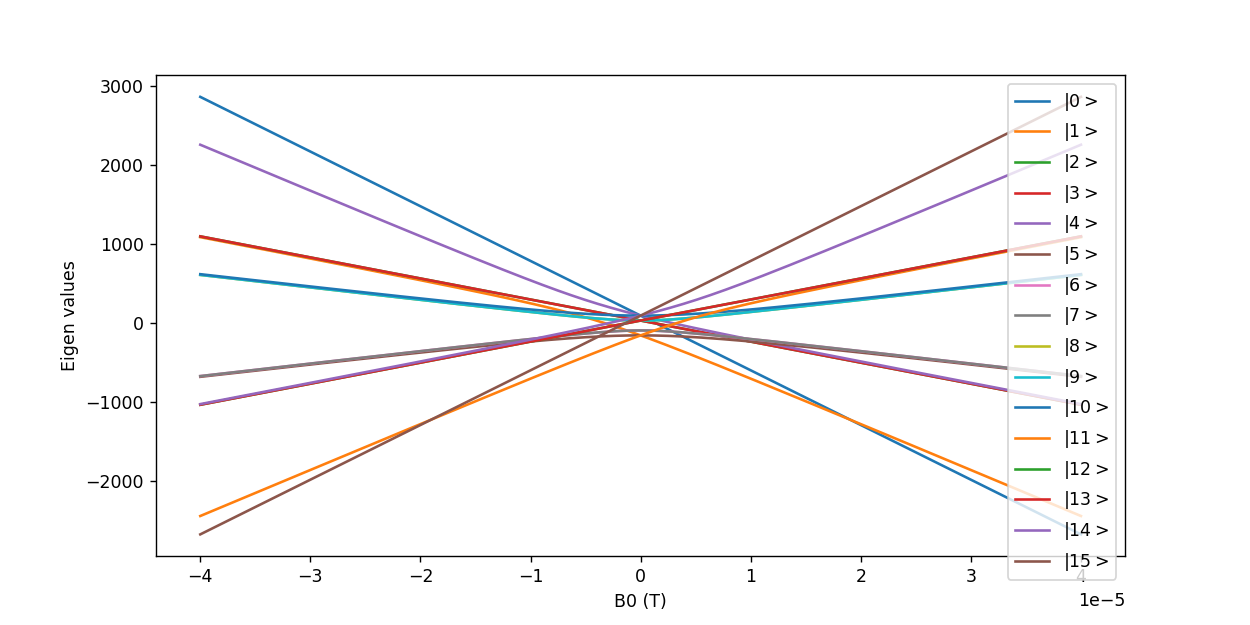

In [31]:
"""
Plotting the eigen value of 16 eigen states with respect to B0(t).
""";

plt.figure(1,(10,5))
for i in range(16):
    plt.plot(B0,EiVa[:,i]/(2.0*np.pi),"-",label=r"$|"+str(i)+">$")

plt.xlabel("B0 (T)")
plt.ylabel("Eigen values")
plt.legend()

<IPython.core.display.Javascript object>


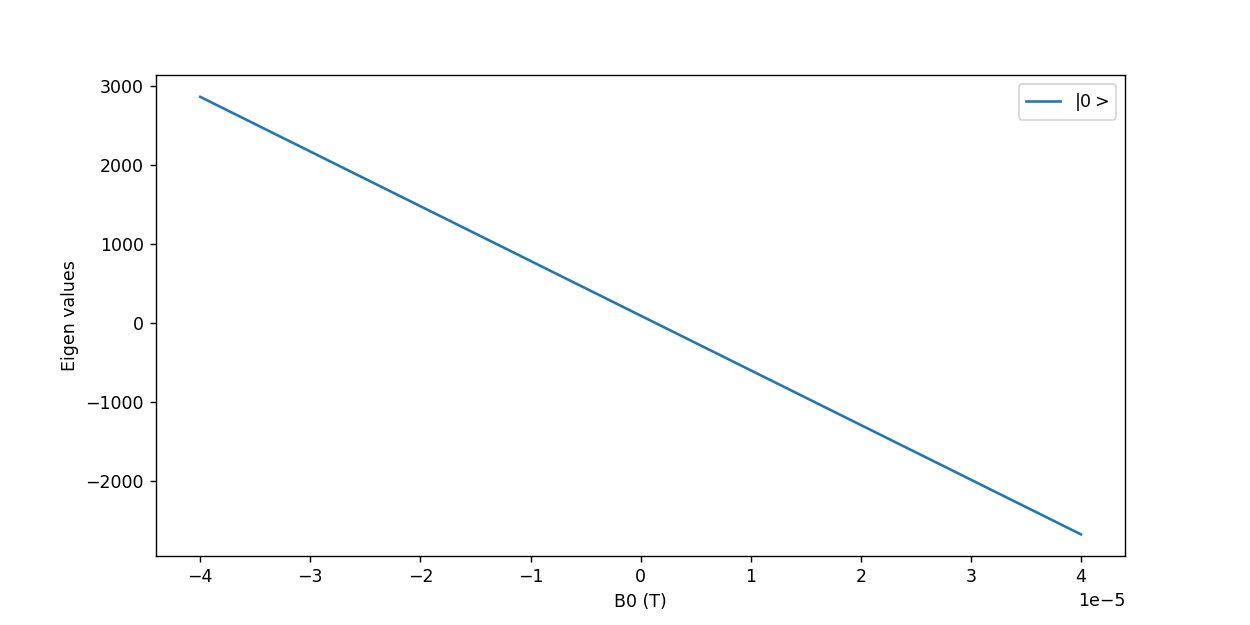

In [32]:
"""
Plotting the eigen value according to total angular momentum.
Total Angular Momentum = 2
""";
plt.figure(2,(10,5))
for i in range(16):
    if Initial_AM[i] == 2:
        plt.plot(B0,EiVa[:,i]/(2.0*np.pi),"-",label=r"$|"+str(i)+">$")

plt.xlabel("B0 (T)")
plt.ylabel("Eigen values")
plt.legend()

<IPython.core.display.Javascript object>


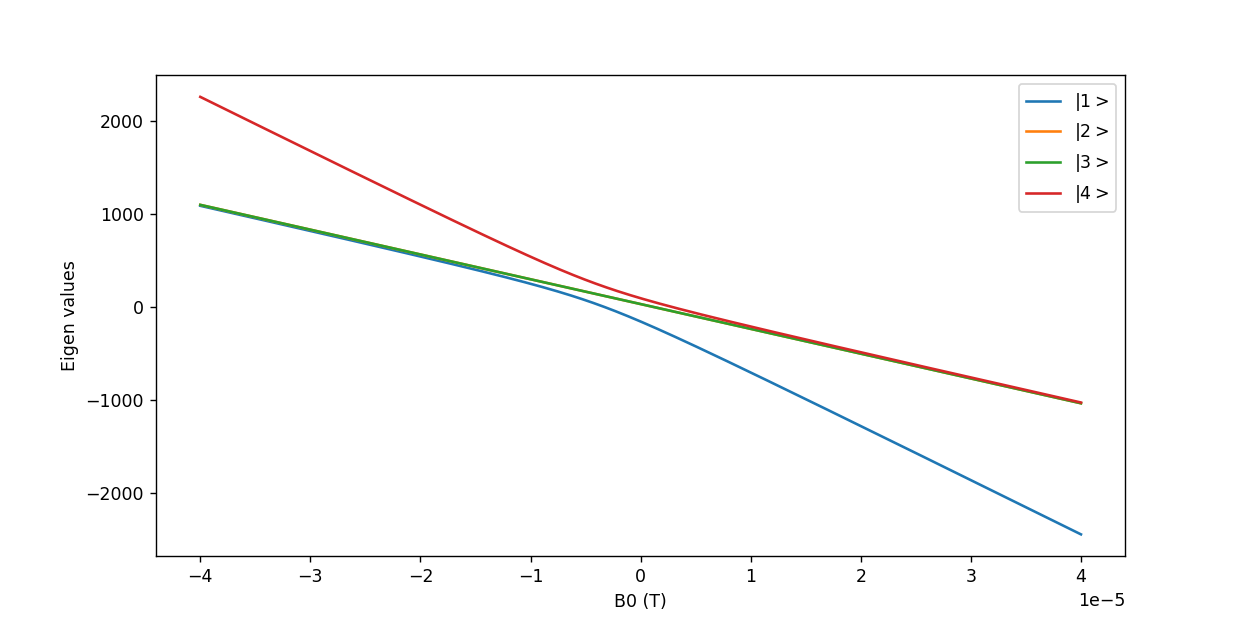

In [33]:
"""
Plotting the eigen value according to total angular momentum.
Total Angular Momentum = 1
""";
plt.figure(3,(10,5))
for i in range(16):
    if Initial_AM[i] == 1:
        plt.plot(B0,EiVa[:,i]/(2.0*np.pi),"-",label=r"$|"+str(i)+">$")

plt.xlabel("B0 (T)")
plt.ylabel("Eigen values")
plt.legend()

<IPython.core.display.Javascript object>


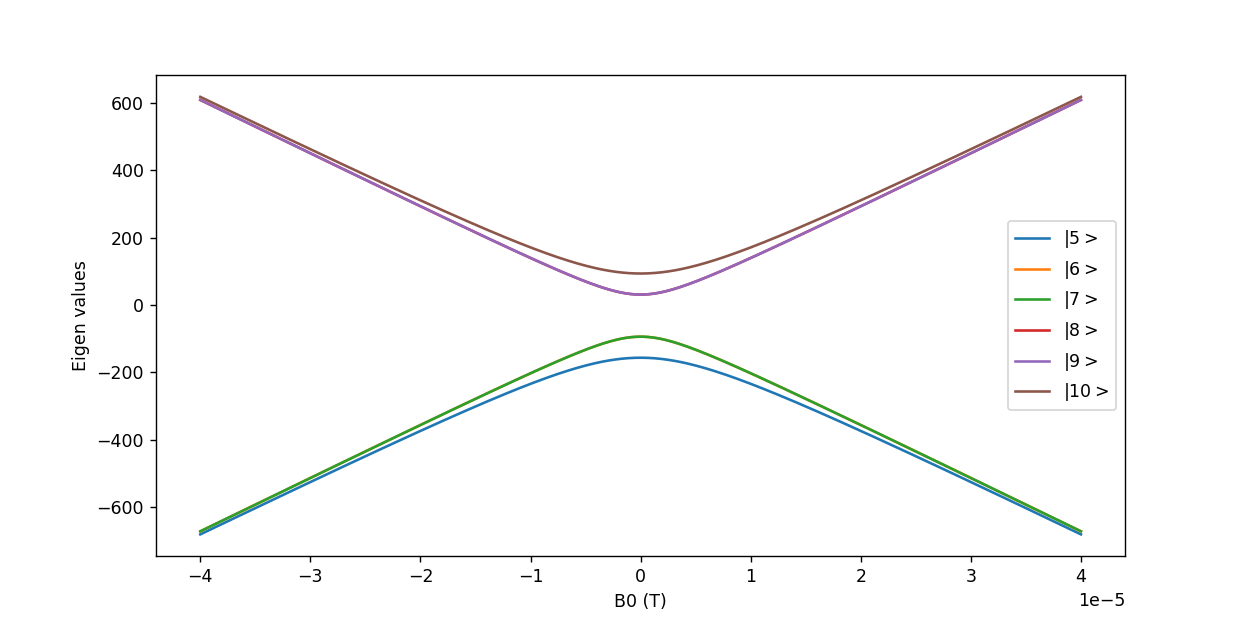

In [34]:
"""
Plotting the eigen value according to total angular momentum.
Total Angular Momentum = 0
""";
plt.figure(4,(10,5))
for i in range(16):
    if Initial_AM[i] == 0:
        plt.plot(B0,EiVa[:,i]/(2.0*np.pi),"-",label=r"$|"+str(i)+">$")

plt.xlabel("B0 (T)")
plt.ylabel("Eigen values")
plt.legend()

<IPython.core.display.Javascript object>


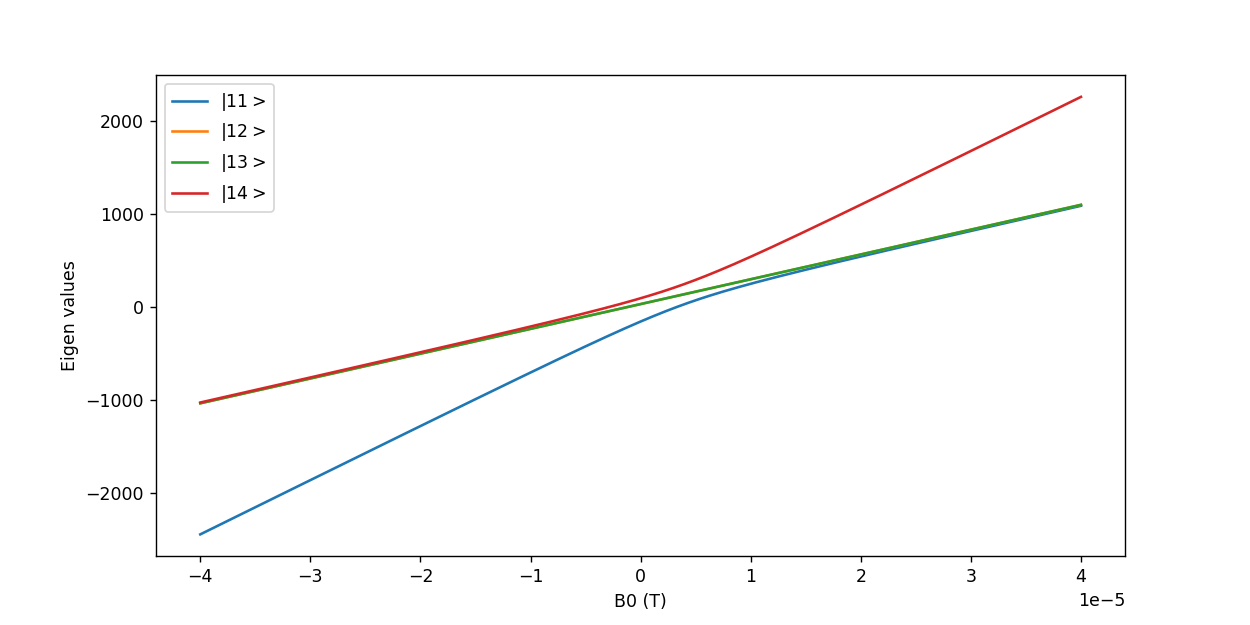

In [35]:
"""
Plotting the eigen value according to total angular momentum.
Total Angular Momentum = -1
""";
plt.figure(5,(10,5))
for i in range(16):
    if Initial_AM[i] == -1:
        plt.plot(B0,EiVa[:,i]/(2.0*np.pi),"-",label=r"$|"+str(i)+">$")

plt.xlabel("B0 (T)")
plt.ylabel("Eigen values")
plt.legend()

<IPython.core.display.Javascript object>


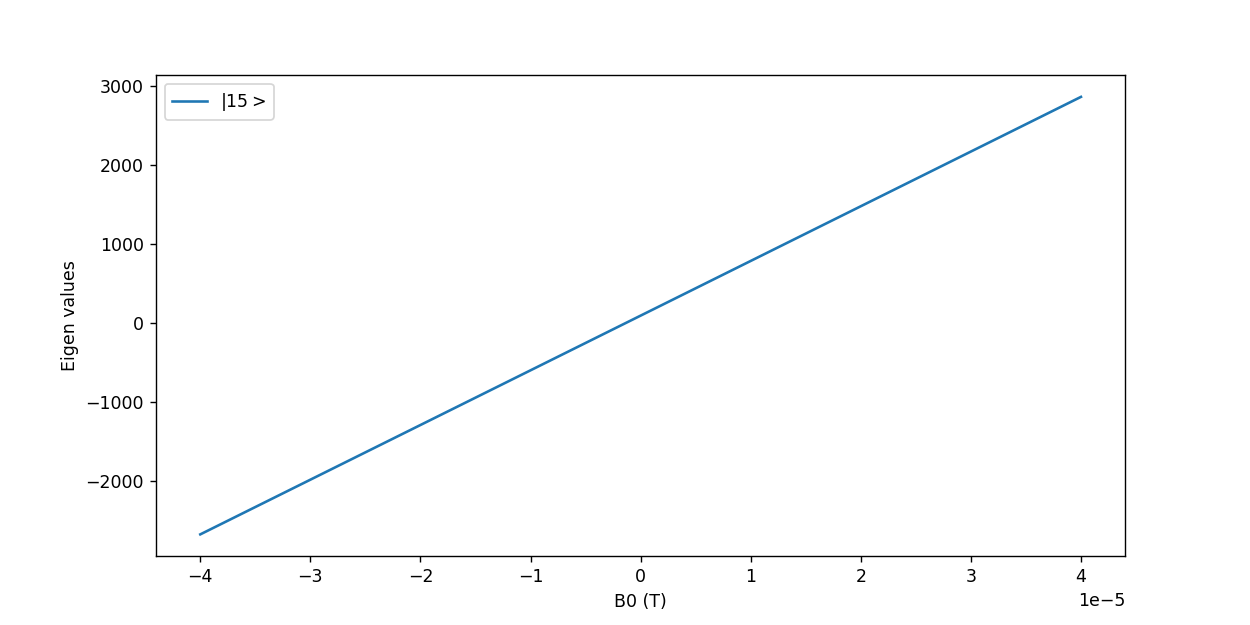

In [36]:
"""
Plotting the eigen value according to total angular momentum.
Total Angular Momentum = -2
""";
plt.figure(6,(10,5))
for i in range(16):
    if Initial_AM[i] == -2:
        plt.plot(B0,EiVa[:,i]/(2.0*np.pi),"-",label=r"$|"+str(i)+">$")

plt.xlabel("B0 (T)")
plt.ylabel("Eigen values")
plt.legend()

## Initial and Final Eigen States 

In [37]:
for i in range(16):
    for j in range(16):
        if np.rint(abs(np.dot(EVRef[0][:,i],EVRef[-1][:,j]))) == 1:
            print("Initial |"+str(i)+">" + " (AM: " + str(Initial_AM[i]) + ")" + " -> " + "Final |"+str(j)+">" + " (AM: " + str(Initial_AM[j]) + ")" )

Initial |0> (AM: 2.0) -> Final |0> (AM: 2.0)
Initial |1> (AM: 1.0) -> Final |4> (AM: 1.0)
Initial |2> (AM: 1.0) -> Final |2> (AM: 1.0)
Initial |3> (AM: 1.0) -> Final |3> (AM: 1.0)
Initial |4> (AM: 1.0) -> Final |1> (AM: 1.0)
Initial |5> (AM: 0.0) -> Final |10> (AM: -0.0)
Initial |6> (AM: 0.0) -> Final |8> (AM: -0.0)
Initial |7> (AM: 0.0) -> Final |9> (AM: -0.0)
Initial |8> (AM: -0.0) -> Final |6> (AM: 0.0)
Initial |9> (AM: -0.0) -> Final |7> (AM: 0.0)
Initial |10> (AM: -0.0) -> Final |5> (AM: 0.0)
Initial |11> (AM: -1.0) -> Final |14> (AM: -1.0)
Initial |12> (AM: -1.0) -> Final |12> (AM: -1.0)
Initial |12> (AM: -1.0) -> Final |13> (AM: -1.0)
Initial |13> (AM: -1.0) -> Final |12> (AM: -1.0)
Initial |13> (AM: -1.0) -> Final |13> (AM: -1.0)
Initial |14> (AM: -1.0) -> Final |11> (AM: -1.0)
Initial |15> (AM: -2.0) -> Final |15> (AM: -2.0)


## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com